## Check for Programmatic variations


Number of exact matches: 156
Matching Statistics for Sent_upgraded:
Number of matches in Sent_upgraded: 1201
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 785
Percentage Matched (%): 83.69

Number of "exact" matches not in golden standard: 150
Precision: 0.6245
Recall: 0.8781
F1 Score: 0.7299

Number of exact matches: 150
Matching Statistics for TransE.5:
Number of matches in TransE.5: 1207
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 786
Percentage Matched (%): 83.80

Number of "exact" matches not in golden standard: 145
Precision: 0.6189
Recall: 0.8772
F1 Score: 0.7258

Number of exact matches: 155
Matching Statistics for Distmult.5:
Number of matches in Distmult.5: 1230
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 821
Percentage Matched (%): 87.53

Number of "exact" matches not in golden standard: 149
Precision: 0.6320
Recall: 0.9062
F1 Score: 0.7447

Number of exact matches: 72
Matching Statistics for NetMf.0.5:
Nu

,Precision,Recall,F1 Score
Sent_upgraded,0.6245,0.8781,0.7299
TransE.5,0.6189,0.8772,0.7258
Distmult.5,0.6320,0.9062,0.7447
NetMf.0.5,1.0000,0.8152,0.8982
Node2vec.0.35,0.8919,0.9413,0.9159


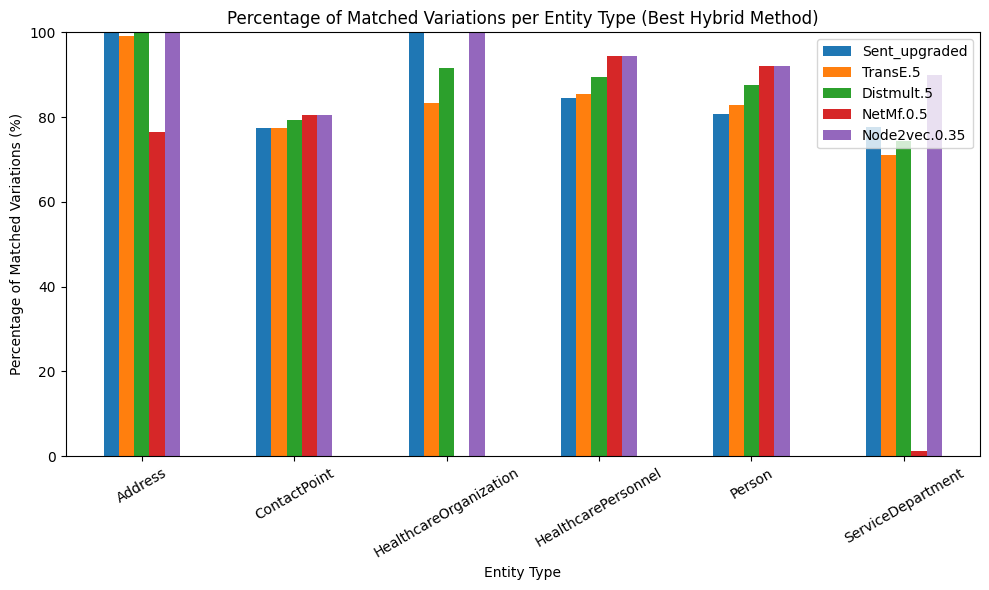

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
noise = 'high'
# Load the CSV and JSON files
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

#Load both match files
match_files = {
    
    'TransE.5' : json.load(open(f'matches_{noise}/HybridTransE_alpha_0.5.json', 'r')),
    'Distmult.5': json.load(open(f'matches_{noise}/HybridDistmult_alpha_0.5.json', 'r')),
    'NetMf.0.5' : json.load(open(f'matches_{noise}/HybridNetMf_alpha_0.5.json', 'r')),
    'Node2vec.0.35': json.load(open(f'matches_{noise}/HybridNode2vecLow_alpha_0.5.json', 'r')),
    'Sent_upgraded': json.load(open(f'matches_{noise}/SentenceEmbedding_top_k5.json', 'r')),
    
}

# # Load the CSV and JSON files
# golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}_updated.csv')

# # Load both match files
# match_files = {
#     'Sent_upgraded': json.load(open(f'matches_{noise}/SentenceEmbedding_top_k5.json', 'r')),
#     'TransE.65' : json.load(open(f'matches_{noise}/HybridTransE_alpha_0.8.json', 'r')),
#     'Distmult.5': json.load(open(f'matches_{noise}/HybridDistmult_alpha_0.5.json', 'r')),
#     'NetMf.8' : json.load(open(f'matches_{noise}/HybridNetMf_alpha_0.8.json', 'r')),
#     'Node2vec.35': json.load(open(f'matches_{noise}/HybridNode2vecLow_alpha_0.35.json', 'r')),
    
# }

def extract_uuid(uri):
    return uri.split("/")[-1]
precision_recall_summary = {} 
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100
    exact_count = sum(1 for item in data if item.get("duplication_type") == "exact")
    print(f"Number of exact matches: {exact_count}")
    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })
    # Calculate precision and recall
    # True Positives (TP): matched pairs that are in golden_standard
    TP = matched
    # False Positives (FP): matched pairs that are NOT in golden_standard
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )

        # Count "exact" matches not in golden standard
    exact_not_in_golden = 0
    for match in data:
        # Extract UUIDs
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1 = extract_uuid(entity1.get("subject"))
        uuid2 = extract_uuid(entity2.get("subject"))
        pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
        # Check if not in golden and duplication_type is exact
        if pair not in golden_pairs_set and match.get("duplication_type") == "exact":
            exact_not_in_golden += 1

    print(f'Number of "exact" matches not in golden standard: {exact_not_in_golden}')
    FP = len(matched_pairs_set - golden_pairs_set) - exact_not_in_golden
    # False Negatives (FN): golden_standard pairs not matched
    FN = len(golden_pairs_set - matched_pairs_set)
    
    # precision, recall, and F1 score calculations
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\f")
    print(f"F1 Score: {F1_score:.4f}\n")

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched

pr_df = pd.DataFrame(precision_recall_summary).T  # Transpose for better display
pr_df = pr_df.round(4)
print("Precision and Recall per Method:")
display(pr_df)

percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (Best Hybrid Method)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   


Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall   F1
Address                       0.0     0.0  0.0
HealthcareOrganization        0.0     0.0  0.0
ServiceDepartment             0.0     0.0  0.0
Person                        0.0     0.0  0.0
HealthcarePersonnel           0.0     0.0  0.0
ContactPoint                  0.0     0.0  0.0

Precision/Recall/F1 per entity type for TransE.5:
                        Precision  Recall   F1
Address                       0.0     0.0  0.0
HealthcareOrganization        0.0     0.0  0.0
ServiceDepartment             0.0     0.0  0.0
Person                        0.0     0.0  0.0
HealthcarePersonnel           0.0     0.0  0.0
ContactPoint                  0.0     0.0  0.0

Precision/Recall/F1 per entity type for Distmult.5:
                        Precision  Recall   F1
Address                       0.0     0.0  0.0
HealthcareOrganization        0.0     0.0  0.0
ServiceDepartment             0.0     0.0

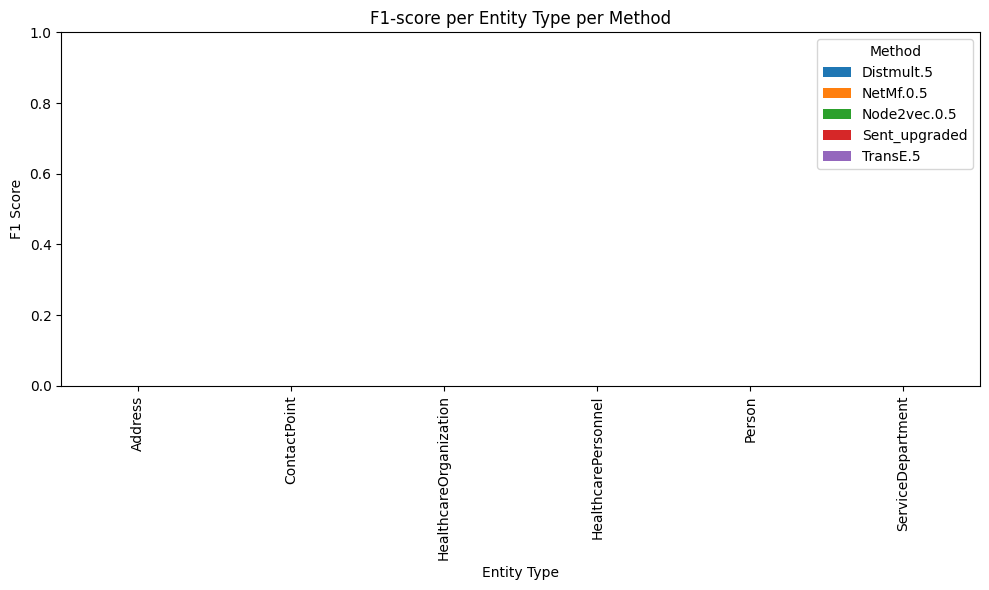

In [18]:
import pandas as pd
import json
import matplotlib.pyplot as plt

noise = 'high'
# Load the CSV and JSON files
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

#Load both match files
match_files = {
    'Sent_upgraded': json.load(open(f'matches_struct_{noise}/SentenceEmbedding_top_k5.json', 'r')),
    'TransE.5' : json.load(open(f'matches_struct_{noise}/HybridTransE_alpha_0.5.json', 'r')),
    'Distmult.5': json.load(open(f'matches_struct_{noise}/HybridDistmult_alpha_0.5.json', 'r')),
    'NetMf.0.5' : json.load(open(f'matches_struct_{noise}/HybridNetMf_alpha_0.5.json', 'r')),
    'Node2vec.0.5': json.load(open(f'matches_struct_{noise}/HybridNode2vecLow_alpha_0.5.json', 'r')),
    
}


def extract_uuid(uri):
    return uri.split("/")[-1]

precision_recall_summary = {}
percent_summary = {}
entity_type_pr_summary = {}

for match_type, data in match_files.items():
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # === PER-ENTITY TYPE PRF computation ===
    prf_per_entity = {}

    # List of entity types in the golden standard
    entity_types = golden_standard['entity_type'].unique()
    # ...existing code...
    for entity_type in entity_types:
        # Filter golden pairs for this entity type
        golden_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        golden_pairs_set = set(
            (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
            for _, row in golden_type_df.iterrows()
        )
        valid_ids = set(golden_type_df['original_id']).union(set(golden_type_df['duplicate_id']))
        found_pairs_set = set(
            (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
            for pair in identifiers
            if pair['entity1'] in valid_ids and pair['entity2'] in valid_ids
        )

        # Find "exact" matches not in golden for this entity type
        exact_not_in_golden = 0
        for match in data:
            # Only consider matches for this entity type
            # (Assumes you have entity_type info in your match or can infer it)
            entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
            entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
            uuid1 = extract_uuid(entity1.get("subject"))
            uuid2 = extract_uuid(entity2.get("subject"))
            pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
            if uuid1 in valid_ids and uuid2 in valid_ids:
                if pair not in golden_pairs_set and match.get("duplication_type") == "exact":
                    exact_not_in_golden += 1

        TP = len(golden_pairs_set & found_pairs_set)
        FP = len(found_pairs_set - golden_pairs_set) - exact_not_in_golden
        FN = len(golden_pairs_set - found_pairs_set)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}
    # ...existing code...
        entity_type_pr_summary[match_type] = prf_per_entity

# Convert results to DataFrames for nice display
entity_prf_dfs = {}
for method, prf_dict in entity_type_pr_summary.items():
    df = pd.DataFrame(prf_dict).T  # entity_type as index
    entity_prf_dfs[method] = df.round(4)

# Display all PRF tables for each method
for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

# If you want a combined table:
combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]
print("\nCombined Precision/Recall/F1 per entity type:")
print(combined_df)

# You can also plot per-entity F1 for all methods
f1_table = combined_df.pivot(index='Entity Type', columns='Method', values='F1')
f1_table.plot(kind='bar', figsize=(10,6))
plt.title('F1-score per Entity Type per Method')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [26]:
import os

# Find all golden standard matches that were NOT found by the last algorithm run in the loop
missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]

print(f"Number of missed matches: {len(missed_rows)}")
missed_rows.head()  # Show a sample
# Save missed matches to CSV for error analysis
os.makedirs("error_analysis", exist_ok=True)
missed_rows.to_csv("error_analysis/missed_matches.csv", index=False)

Number of missed matches: 72


In [27]:
missed_rows

,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric
128,827254df-3830-4e4b-83d4-540a526aea43,80e93367-96cf-438d-891a-f6d47d1a2e42,ServiceDepartment,translation,serviceDepartmentName,Renal,Nier
140,02246f10-ce65-4211-a3c9-c8d76ceb1865,80c9baa6-cef7-400f-af6b-a7b36b831142,ServiceDepartment,department_typo,serviceDepartmentName,Optometric,Optoemtric
141,6850f3a3-4507-4b46-b271-3810c5030168,f7adb544-13f5-47f3-ba45-5369bfe0ec9a,ServiceDepartment,department_abbreviation,serviceDepartmentName,Gynecologic,GYN
158,8034f222-b4a4-45c3-b4dc-5b1949523e70,5e681aa2-4b3f-4154-968c-b9421016fb47,ServiceDepartment,alternative_naming,serviceDepartmentName,Endocrine,Hormone & Metabolism Center
...,...,...,...,...,...,...,...
908,da47b8f9-cee4-4404-9648-1f4b0c747a90,5171b7ad-fdfa-4d79-af7d-c2965f675adf,ContactPoint,translation,contactType,staff,personeel
910,799c82ee-f742-453b-a7a1-28de18310104,044ffa08-ce4d-4371-9951-07cbd3935bf7,ContactPoint,translation,contactType,information,teave
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord


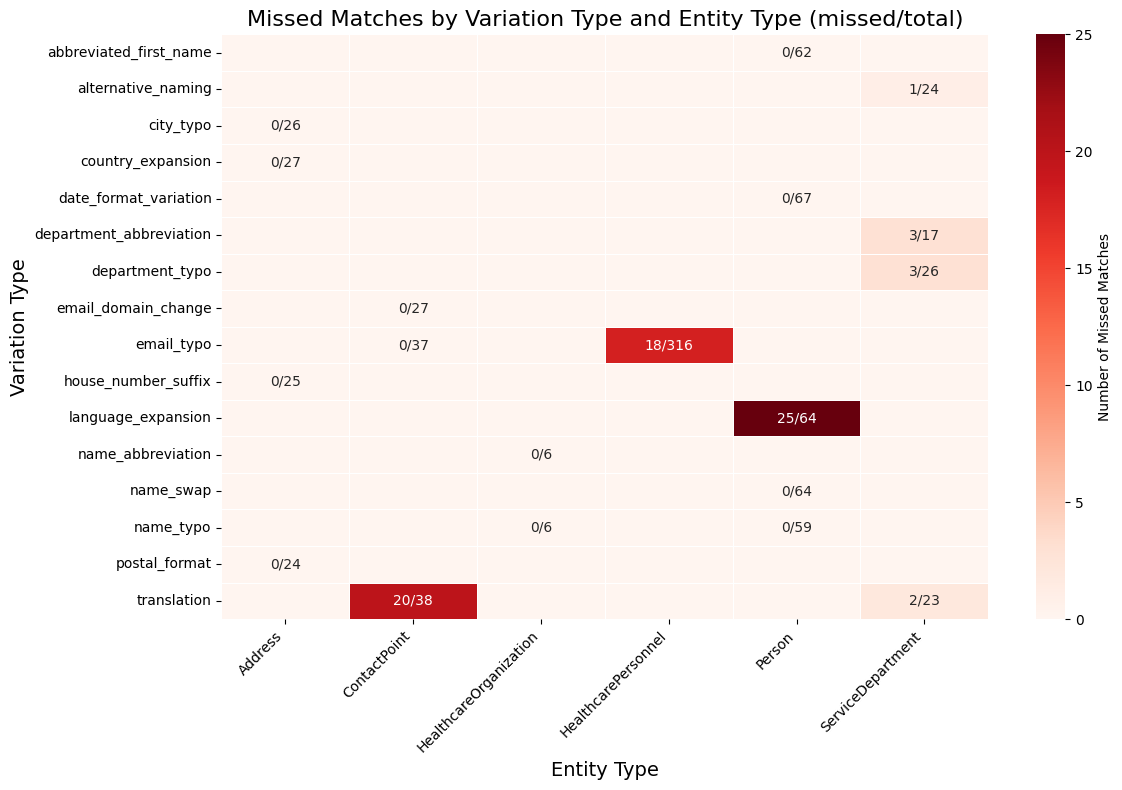

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missed_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)


# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of true duplicates in Node2vec.0.5: 190
Number of tru

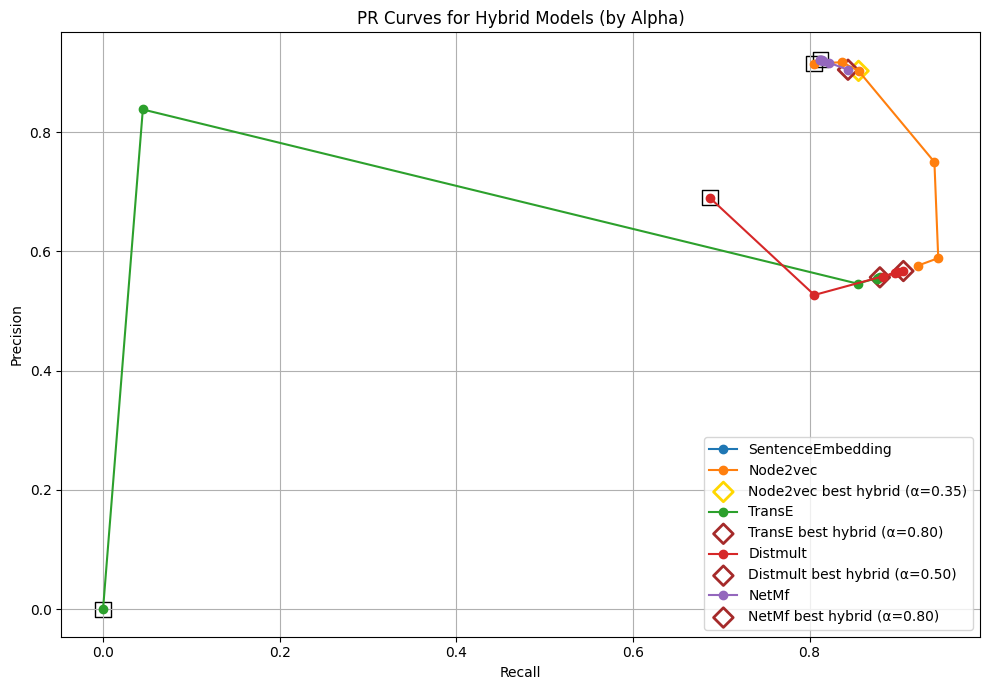

In [9]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
noise = 'high'
# Path and file setup
match_dir = f"matches_{noise}"
model_bases = {
    'SentenceEmbedding': "SentenceEmbedding_top_k5",
    'Node2vec': "HybridNode2vecLow_alpha_",
    'TransE': "HybridTransE_alpha_",
    'Distmult': "HybridDistmult_alpha_",
    'NetMf': "HybridNetMf_alpha_",
}
alpha_values = [0.0, 0.2, 0.35, 0.5, 0.65, 0.8, 1.0]

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

def evaluate_matches(match_data, golden_standard):
    identifiers = []
    for match in match_data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) or
                (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])
                for pair in identifiers
            ),
            axis=1
        )
    ]

    true_duplicates = [
        pair for match in data
        for pair in [{
            'entity1': extract_uuid(next(e['entity1'] for e in match['entities'] if 'entity1' in e).get("subject")),
            'entity2': extract_uuid(next(e['entity2'] for e in match['entities'] if 'entity2' in e).get("subject"))
        }]
        if (
            ('duplication_type' in match and match['duplication_type'] == 'exact') or
            ('avg_literal_similarity' in match and str(match['avg_literal_similarity']) == '1.0')
        )
    ]
    print(f"Number of true duplicates in {match_type}: {len(true_duplicates)}")

    TP = len(matched_rows)
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    FP = len(matched_pairs_set - golden_pairs_set) 
    FN = len(golden_pairs_set - matched_pairs_set)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Prepare to store results
pr_curves = {model: {'precisions': [], 'recalls': [], 'alphas': []} for model in model_bases.keys()}

for model, base in model_bases.items():
    for alpha in alpha_values:
        if alpha == 1.0:
            filename = os.path.join(match_dir, "SentenceEmbedding.json")
        else:
            filename = os.path.join(match_dir, f"{base}{alpha}.json")
        if not os.path.exists(filename):
            continue
        with open(filename, 'r') as f:
            match_data = json.load(f)
        precision, recall = evaluate_matches(match_data, golden_standard)
        pr_curves[model]['precisions'].append(precision)
        pr_curves[model]['recalls'].append(recall)
        pr_curves[model]['alphas'].append(alpha)

# Find the best model and alpha (highest F1 among all models and alphas except alpha=1.0)
best_model = None
best_alpha = None
best_f1 = -1
best_idx = None

for model, curve in pr_curves.items():
    for i, (p, r, a) in enumerate(zip(curve['precisions'], curve['recalls'], curve['alphas'])):
        if a == 1.0:
            continue  # skip SentenceEmbedding
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_alpha = a
            best_idx = i

plt.figure(figsize=(10, 7))

# Plot SentenceEmbedding (alpha=1.0) only once
if 'SentenceEmbedding_top_k5.json' in [os.path.basename(os.path.join(match_dir, "SentenceEmbedding_top_k5.json"))]:
    se_precision, se_recall = None, None
    for model, curve in pr_curves.items():
        for i, alpha in enumerate(curve['alphas']):
            if alpha == 1.0:
                se_precision = curve['precisions'][i]
                se_recall = curve['recalls'][i]
                break
    if se_precision is not None and se_recall is not None:
        plt.scatter(se_recall, se_precision, marker='*', s=200, color='black', label='SentenceEmbedding (α=1.0)')

# Plot each model's PR curve, highlight best hybrid, and highlight alpha=0.0
for model, curve in pr_curves.items():
    hybrid_recalls = [r for a, r in zip(curve['alphas'], curve['recalls']) if a != 1.0]
    hybrid_precisions = [p for a, p in zip(curve['alphas'], curve['precisions']) if a != 1.0]
    hybrid_alphas = [a for a in curve['alphas'] if a != 1.0]
    plt.plot(hybrid_recalls, hybrid_precisions, marker='o', label=model)
    # Highlight starting point (alpha=0.0)
    if 0.0 in curve['alphas']:
        idx0 = curve['alphas'].index(0.0)
        plt.scatter(curve['recalls'][idx0], curve['precisions'][idx0], marker='s', s=120, color='none', edgecolor='black')
    # Find best hybrid (highest F1)
    best_idx_model = None
    best_f1_model = -1
    for i, (p, r) in enumerate(zip(hybrid_precisions, hybrid_recalls)):
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1_model:
            best_f1_model = f1
            best_idx_model = i
    if best_idx_model is not None:
        marker_color = 'gold' if model == best_model else 'brown'
        plt.scatter(hybrid_recalls[best_idx_model], hybrid_precisions[best_idx_model], marker='D', s=100, edgecolor=marker_color, facecolor='none', linewidths=2, label=f"{model} best hybrid (α={hybrid_alphas[best_idx_model]:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for Hybrid Models (by Alpha)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Matching Statistics for Hacky:
Number of matches in Hacky: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Matching Statistics for Sent_filtered2:
Number of matches in Sent_filtered2: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 764
Percentage Matched (%): 81.45

Matching Statistics for TransE:
Number of matches in TransE: 0
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 0
Percentage Matched (%): 0.00

Matching Statistics for Distmult:
Number of matches in Distmult: 569
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 590
Percentage Matched (%): 62.90

Matching Statistics for Node2vec:
Number of matches in Node2vec: 354
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 271
Percentage Matched (%): 28.89

Matching Statistics for NetMf:
Number of matches in NetMf: 607
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 685
Percentage Ma

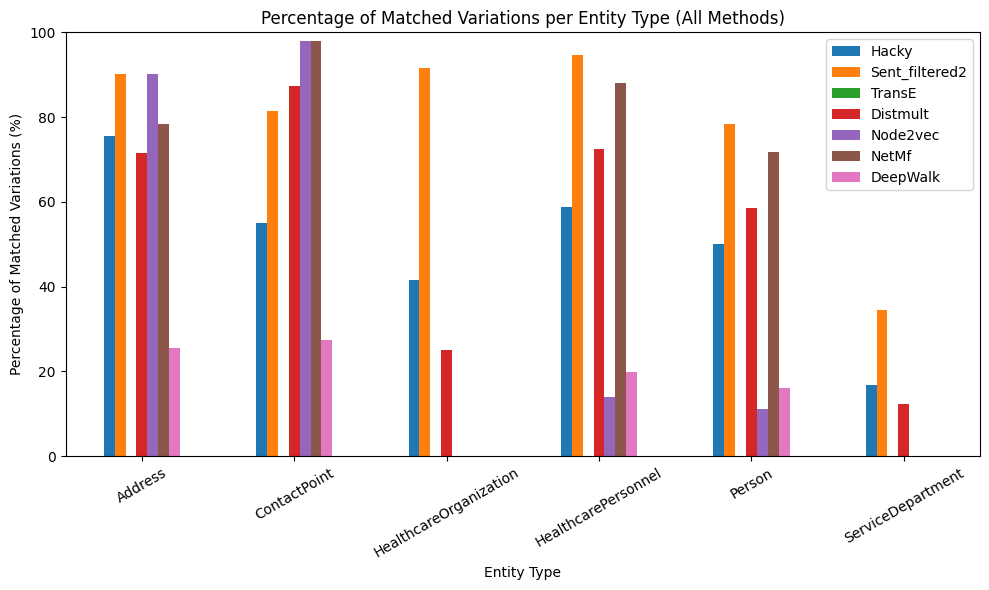

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Sent_flat': json.load(open('matches/matchesHacky.json', 'r')),
    'Sent_upgraded': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches/HybridTransE_alpha_0.0.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_alpha_0.0.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_alpha_0.0.json', 'r')),
    'NetMf' : json.load(open('matches/HybridNetMf_alpha_0.0.json', 'r')),
    'DeepWalk' : json.load(open('matches/HybridDeepWalk_alpha_0.0.json', 'r')),
    


}

def extract_uuid(uri):
    return uri.split("/")[-1]
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched


percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   